<a href="https://www.kaggle.com/code/irfanqasim/brain-mri-segmentation?scriptVersionId=113173206" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction
The early detection and treatment of brain tumour
helps in early diagnosis which aids in reducing mortality
rate. Image processing has been widespread in recent
years and it has been an inevitable part in the medical
field also. The abnormal growth of cells in the brain
causes brain tumour. Brain tumour is also referred to as
intracranial neoplasm. The two types of tumours are
malignant and benign tumours. Standard MRI sequences
are generally used to differentiate between different types
of brain tumours based on visual qualities and contrast
texture analysis of the soft tissue.
Low-grade gliomas (LGGs) consist of grade I tumors and we implement UNet model on these tumor image dataset.

![image](http:///www.verywellhealth.com/thmb/wL4lJsbRT_NCq325QpM8I91blYU=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-1190799984-ea0c55d36c014836b8244bf021d614b0.jpg)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Importing libraries

Note: We will import required libraries as and when required throughout this notebook

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cv2
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras import backend as K


#### Input image height and width

In [5]:
img_height=256
img_width=256

In [6]:
# image_train_files = []

# mask_files = glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*")
# all_files = glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*")
# print(len(all_files))
# print(len(mask_files))
# for i in all_files:
#     if i not in mask_files:
#         image_train_files.append(i)
        
# print(len(image_train_files))

#### Loading Data

In [7]:
data_path = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    # starts at sub_dir_path = /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909
    try:
        #dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            #starts at filename = TCGA_CS_4941_19960909_1.tif
            file_path = sub_dir_path + '/' + filename
            data_path.append(file_path)
            #data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [8]:
data_path[1:10]

['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif']

#### Creating dataframe

In [9]:
df = pd.DataFrame(data={"img_path": data_path})
df

img_path
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...                                                 ...
7853  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7857  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

[7858 rows x 1 columns]

In [10]:
# Seperating the original image paths and mask image paths
orig_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

#### Sorting the file paths so that the same file numbers for both original image and mask image are present at a given index location in both the dataframes
#### We have to sort based on the numbers present in the end of the file path (before`.tif` extension in case of original image files and before `_mask.tif` in case of mask image files.

In [11]:
# We find that the numbers index location is 89 and we have to fetch until until -4 index(.tif) in case of 
# orig_img files and until -9 index(_mask.tif) postion in case of mask files
imgs = sorted(orig_img["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[89:-9]))

# Sorting check
idx = np.random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_25.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_25_mask.tif


#### Dataframe consisting paths of original image and corresponding masks

In [12]:
df = pd.DataFrame({"image_path": imgs, 'mask_path':masks})
df

image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
...                                                 ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  

[3929 rows x 2 columns]

In [13]:
indd = np.random.randint(1, len(df))
df.iloc[indd]['image_path'], df.iloc[indd]['mask_path']

('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_26.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_26_mask.tif')

In [14]:
# Check whether mask is present or not
def check_mask(mask_path):
    img = cv2.imread(mask_path)
    max_val = img.max()
    if max_val > 0:
        return 1
    else:
        return 0

In [15]:
# Creating a new 'mask' column which shows if mask is present or not
df['mask'] = df['mask_path'].apply(lambda x: check_mask(x))
df

image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  

[3929 rows x 3 columns]

In [16]:
print(f"Number of images with mask: {len(df[df['mask'] == 1])}")
print(f"Number of images without mask: {len(df[df['mask'] == 0])}")

Number of images with mask: 1373
Number of images without mask: 2556


In [17]:
df.iloc[2]['mask']

0

### Visualising our dataset

Image id: 1999
Image id: 2002
Image id: 2003


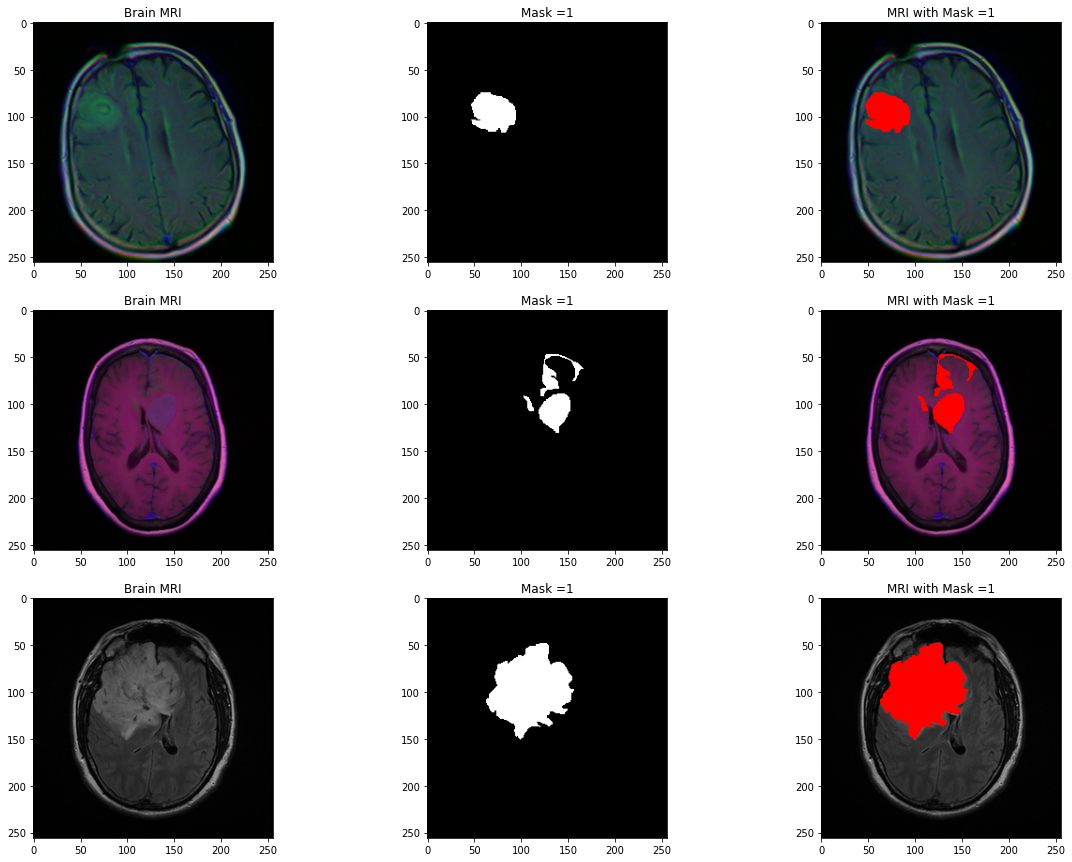

In [18]:
from IPython.display import Image
from skimage import io

count = 0
# generating random number for geenrating random image
i = np.random.randint(len(df)-3)

fig,axes = plt.subplots(3,3, figsize=(20,15))
for mask in df['mask']:
    # plot only if the generated random index mask is 1, otherwise increment 1
    if df.iloc[i]['mask'] == 1:
    #if (mask==1):
        print("Image id: {}".format(i))
        img = io.imread(df.image_path[i])
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][0].title.set_text("Brain MRI")
        axes[count][0].imshow(img)
        
        mask = io.imread(df.mask_path[i])
        axes[count][1].title.set_text("Mask =" + str(df['mask'][i]))
        axes[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][2].title.set_text("MRI with Mask =" + str(df['mask'][i]))
        axes[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.show()

/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif
/kaggle/input/lgg-mri-seg

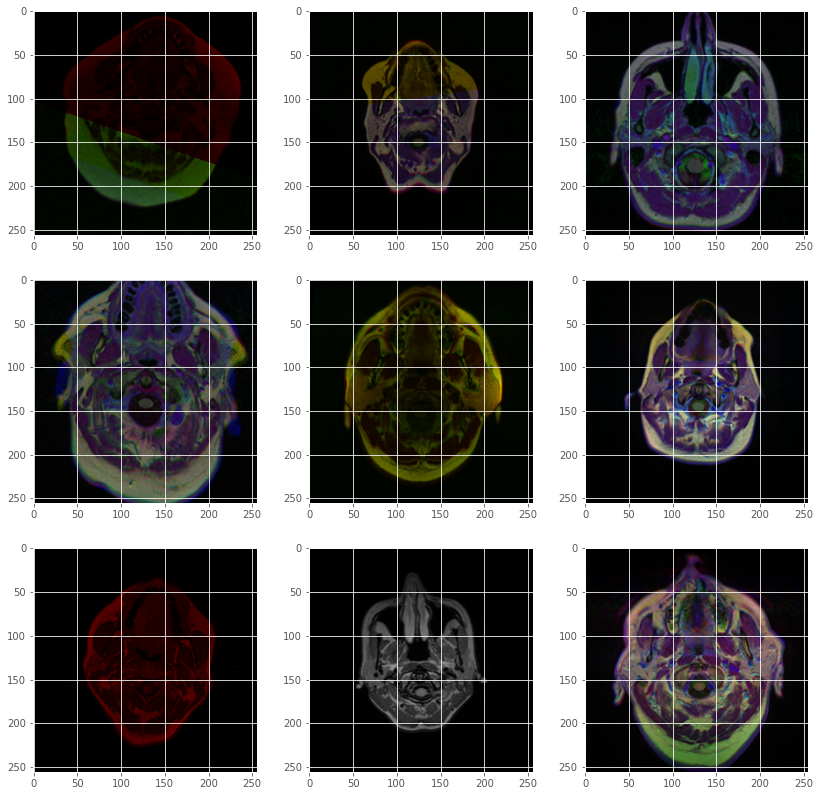

In [19]:
def plot_from_path(rows, col, img_pth, mask_pth):
    fig = plt.figure(figsize=(14,14))
    plt.style.use("ggplot")
    for i in range(rows*col):
        fig.add_subplot(rows, col, i+1)
        print(img_pth[i])
        img = cv2.imread(img_pth[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(mask_pth[i])
        mask = cv2.imread(mask_pth[i])
        plt.imshow(img)
        plt.imshow(mask, cmap='gray', alpha=.1)
    plt.show()

plot_from_path(3,3, df.image_path, df.mask_path)

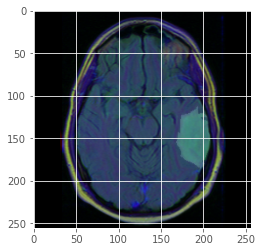

In [20]:
# Checking a random image
img_ck = cv2.imread(df.image_path[818])
msk_ck = cv2.imread(df.mask_path[818])
img_ck = cv2.cvtColor(img_ck, cv2.COLOR_BGR2RGB)
img_ck = img_ck/255
msk_ck = msk_ck/255
plt.imshow(img_ck)
plt.imshow(msk_ck, cmap='gray', alpha=.1)

In [21]:
# maximum and minimum pixel values
print(img_ck.max(),img_ck.min())
print(msk_ck.max(), msk_ck.min())

0.8588235294117647 0.0
1.0 0.0


### Train, test and validation split

In [22]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2)
# validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=2)
print("Train shape: {}\nTest shape: {}\nValidation shape: {}".format(df_train.shape, df_test.shape, df_val.shape))

Train shape: (2828, 3)
Test shape: (393, 3)
Validation shape: (708, 3)


Passing data batchwise to my model using a data generator.

*After mask normalization if a particular value is less than 0.5, then that mask will be considered complete black without any tumor.*

In [23]:
# normalising and setting mask threshold
def normalise_and_set_threshold(image, mask):
    image = image/255
    mask = mask/255
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return (image, mask)

### Image Data Generator

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_generator(dataframe, batch_size, augmentation_dict, target_size = (256,256), image_color_mode='rgb', 
                    mask_color_mode='grayscale', image_save_prefix='image', mask_save_prefix='mask',
                   save_to_dir= None, seed=2):
    
    # ImageDataGenerator generate batches of tensor image data with real-time data augmentation.
    image_data_generator = ImageDataGenerator(**augmentation_dict)
    mask_data_generator = ImageDataGenerator(**augmentation_dict)
    
    image_generator = image_data_generator.flow_from_dataframe(dataframe=dataframe,
                                                              x_col = 'image_path',
                                                              target_size=target_size,
                                                              color_mode = image_color_mode,
                                                              class_mode=None,  # modes for yielding the target, None means no targets returned
                                                              batch_size=batch_size,
                                                              seed=seed,
                                                              save_to_dir=save_to_dir,
                                                              save_prefix=image_save_prefix)
    mask_generator = mask_data_generator.flow_from_dataframe(dataframe = dataframe,
                                                            x_col= 'mask_path',
                                                            target_size = target_size,
                                                            color_mode = mask_color_mode,
                                                            class_mode = None,
                                                            batch_size = batch_size,
                                                            seed = seed,
                                                            save_to_dir= save_to_dir,
                                                            save_prefix= mask_save_prefix)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = normalise_and_set_threshold(img, mask)
        yield (img, mask)

Dice Score is given by 2 times the area of overlap divided by total number of pixels in both images.

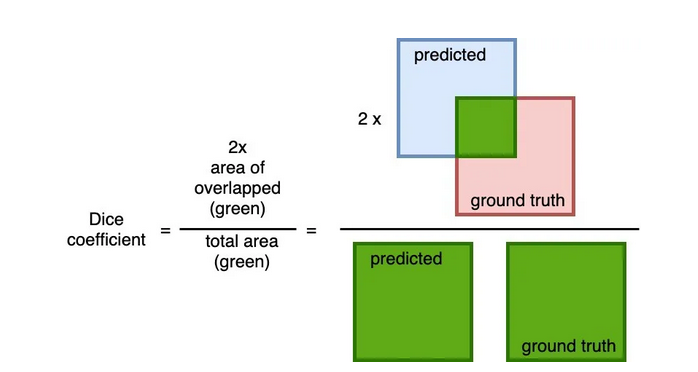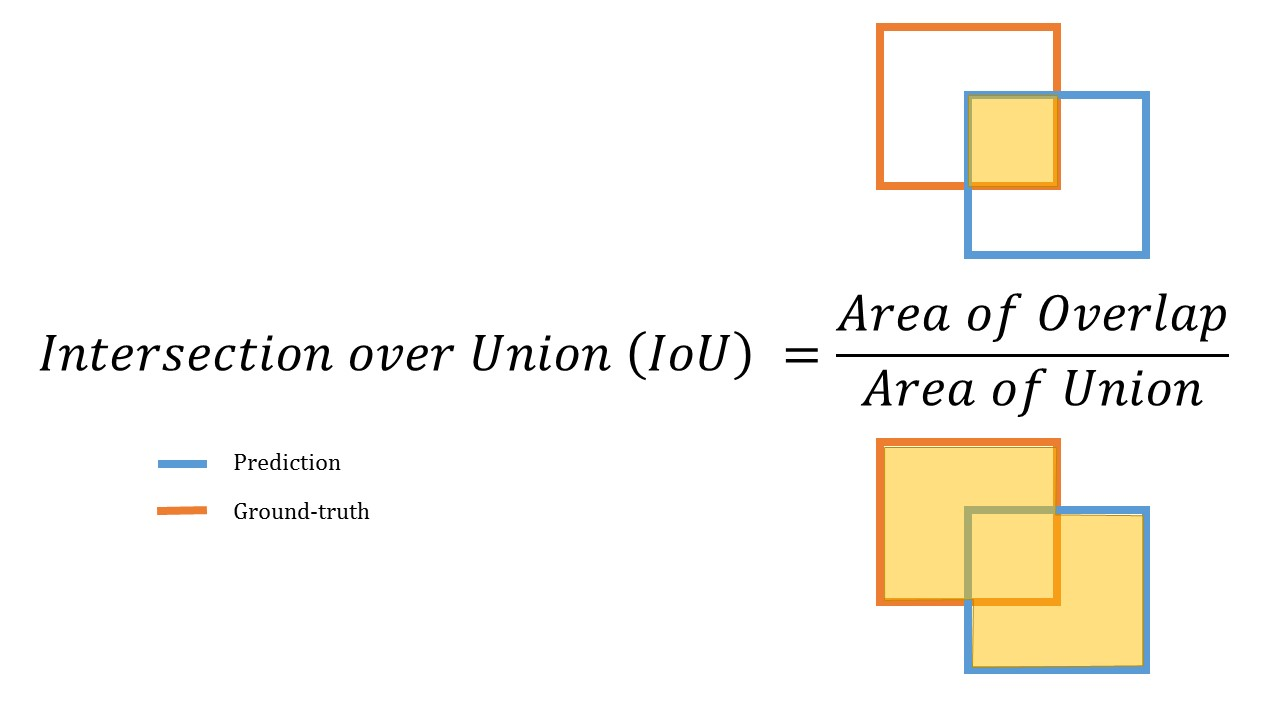

In [25]:
def dice_coeff(ytrue, ypred, smooth=100):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    
    intersection = K.sum(ytrue_flat * ypred_flat)
    total_area = K.sum(ytrue_flat) + K.sum(ypred_flat)
    return (2*intersection + smooth)/(total_area + smooth)

def dice_coeff_loss(ytrue,ypred, smooth=100):
    return 1-dice_coeff(ytrue, ypred, smooth)

def iou_coeff(ytrue, ypred, smooth=100):
    intersection = K.sum(ytrue * ypred)
    union = K.sum(ytrue + ypred) - intersection
    return (intersection + smooth)/(union + smooth)

def jaccard_distance(ytrue, ypred):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    return 1-iou_coeff(ytrue_flat, ypred_flat)

## UNET Architecture

![unet](http://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [26]:
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, 
                                     Dropout, Activation, BatchNormalization, concatenate)
from tensorflow.keras.models import Model, load_model, save_model

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    # Expansion Path or Encoder network
    c1 = Conv2D(filters=64, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(inputs)
    c1 = Conv2D(filters=64, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c1)
    bn1 = BatchNormalization(axis=3)(c1)
    p1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    
    c2 = Conv2D(filters=128, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p1)
    c2 = Conv2D(filters=128, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c2)
    bn2 = BatchNormalization(axis=3)(c2)
    p2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    c3 = Conv2D(filters=256, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p2)
    c3 = Conv2D(filters=256, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c3)
    bn3 = BatchNormalization(axis=3)(c3)
    p3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    c4 = Conv2D(filters=512, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p3)
    c4 = Conv2D(filters=512, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c4)
    bn4 = BatchNormalization(axis=3)(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    c5 = Conv2D(filters=1024, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p4)
    c5 = Conv2D(filters=1024, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c5)
    bn5 = BatchNormalization(axis=3)(c5)
    
    # Compression path or Decoder network
    u6 = Conv2DTranspose(filters = 512, kernel_size=(2,2), strides=(2,2), padding='same')(bn5)
    u6 = concatenate([u6,c4], axis=3)
    c6 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u6)
    c6 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c6)
    bn6 = BatchNormalization(axis=3)(c6)
    
    u7 = Conv2DTranspose(filters = 256, kernel_size=(2,2), strides=(2,2), padding='same')(bn6)
    u7 = concatenate([u7,c3], axis=3)
    c7 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u7)
    c7 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c7)
    bn7 = BatchNormalization(axis=3)(c7)
    
    u8 = Conv2DTranspose(filters = 128, kernel_size=(2,2), strides=(2,2), padding='same')(bn7)
    u8 = concatenate([u8,c2], axis=3)
    c8 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u8)
    c8 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c8)
    bn8 = BatchNormalization(axis=3)(c8)
    
    u9 = Conv2DTranspose(filters = 64, kernel_size=(2,2), strides=(2,2), padding='same')(bn8)
    u9 = concatenate([u9,c1], axis=3)
    c9 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u9)
    c9 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c9)
    bn9 = BatchNormalization(axis=3)(c9)
    
    c10 = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(bn9)
    
    return Model(inputs=[inputs], outputs = [c10])

### Augmentation

In [27]:
augmentation_dict = dict(rotation_range=0.1,
                        width_shift_range = 0.05,
                        height_shift_range = 0.05,
                        brightness_range = (0.2,1.3),
                        shear_range = 0.1,
                        zoom_range = 0.1,
                        horizontal_flip = True,
                        vertical_flip = True,
                        fill_mode = 'nearest')

batch_size = 32
epochs = 150
learning_rate = 1e-3

train_gen = train_generator(df_train, batch_size, augmentation_dict, target_size = (img_height, img_width))
val_gen = train_generator(df_val, batch_size, dict(), target_size=(img_height, img_width))


In [28]:
# initializing our unet model
model = unet(input_size = (img_height, img_width, 3))

2022-12-07 03:06:39.578697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 03:06:39.673424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 03:06:39.674206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 03:06:39.676129: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Compiling and summary

In [29]:
# setting our optimizer and compiling
decay_rate = learning_rate/epochs

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,
                                    epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=optimizer, loss=dice_coeff_loss, metrics=['binary_accuracy',dice_coeff, iou_coeff])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

### Callbacks

In [40]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=25, monitor='val_dice_coeff', 
                                                 mode = 'max', restore_best_weights=True),
                tf.keras.callbacks.ModelCheckpoint('mri_seg_unet.hdf5', verbose=1, 
                                                   save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir='logs')]
#my_callbacks = [tf.keras.callbacks.ModelCheckpoint('mri_seg_unet.hdf5', verbose=1, save_best_only=True)]

2022-12-07 05:38:37.024188: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 05:38:37.024244: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-07 05:38:37.286898: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-07 05:38:37.287088: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


### Fitting our Model

In [41]:
steps_per_epoch = len(df_train)/batch_size
val_steps = len(df_val)/batch_size

history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[my_callbacks], 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/150
 1/88 [..............................] - ETA: 2:23 - loss: 0.2226 - binary_accuracy: 0.9961 - dice_coeff: 0.7774 - iou_coeff: 0.6366

2022-12-07 05:38:50.088562: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 05:38:50.088614: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/88 [..............................] - ETA: 1:37 - loss: 0.1706 - binary_accuracy: 0.9967 - dice_coeff: 0.8294 - iou_coeff: 0.7124

2022-12-07 05:38:51.394800: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-07 05:38:51.397876: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-07 05:38:51.541905: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 619 callback api events and 614 activity events. 
2022-12-07 05:38:51.563452: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-07 05:38:51.588640: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_07_05_38_51

2022-12-07 05:38:51.606544: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_07_05_38_51/2eb969296a26.trace.json.gz
2022-12-07 05:38:51.653473: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

88/88 [==============================] - 95s 1s/step - loss: 0.2851 - binary_accuracy: 0.9957 - dice_coeff: 0.7148 - iou_coeff: 0.5688 - val_loss: 0.2209 - val_binary_accuracy: 0.9963 - val_dice_coeff: 0.7667 - val_iou_coeff: 0.6337

Epoch 00001: val_loss improved from inf to 0.22090, saving model to mri_seg_unet.hdf5
Epoch 2/150
88/88 [==============================] - 89s 1s/step - loss: 0.2664 - binary_accuracy: 0.9962 - dice_coeff: 0.7339 - iou_coeff: 0.5923 - val_loss: 0.3080 - val_binary_accuracy: 0.9959 - val_dice_coeff: 0.6916 - val_iou_coeff: 0.5406

Epoch 00002: val_loss did not improve from 0.22090
Epoch 3/150
88/88 [==============================] - 90s 1s/step - loss: 0.2932 - binary_accuracy: 0.9956 - dice_coeff: 0.7044 - iou_coeff: 0.5582 - val_loss: 0.3542 - val_binary_accuracy: 0.9951 - val_dice_coeff: 0.6535 - val_iou_coeff: 0.4975

Epoch 00003: val_loss did not improve from 0.22090
Epoch 4/150
88/88 [==============================] - 90s 1s/step - loss: 0.5549 - bina

#### Post training visualisation

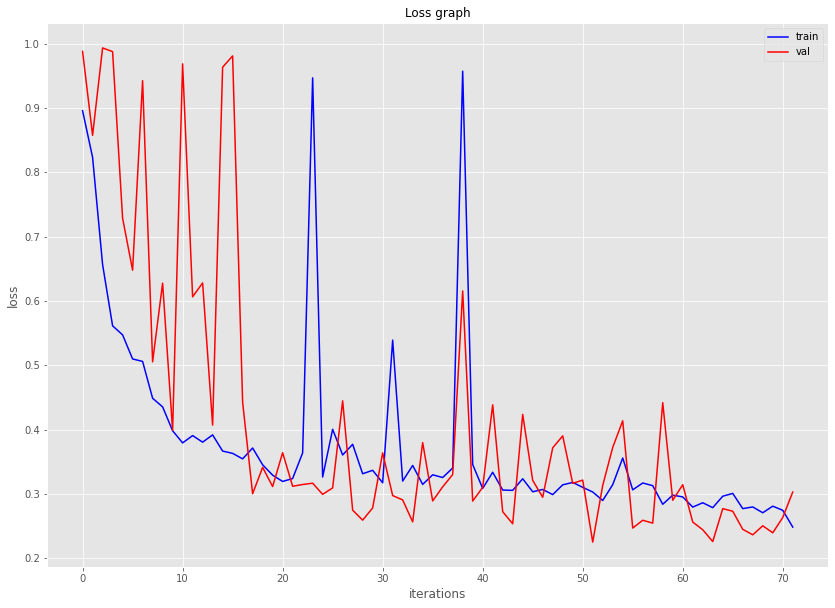

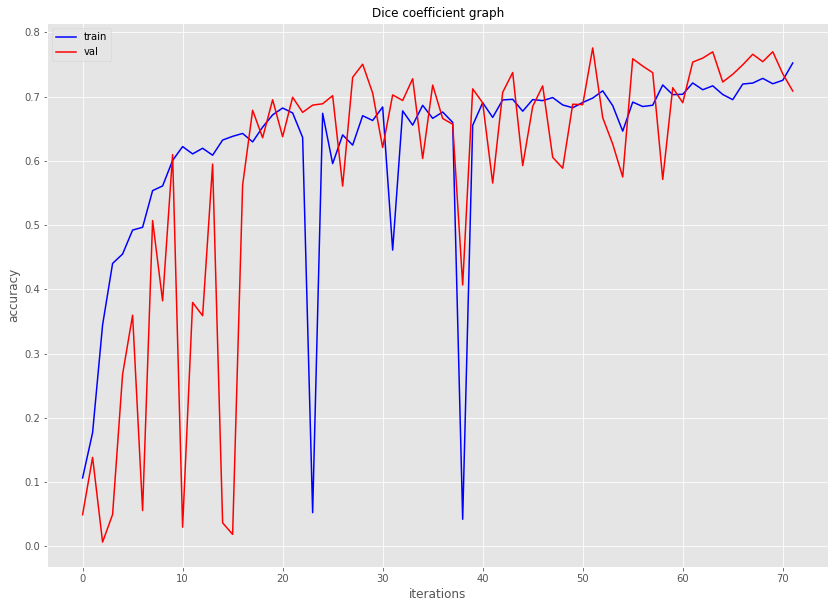

In [32]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coeff']
val_dice_coeff_list = history_post_training['val_dice_coeff']

train_jaccard_list = history_post_training['iou_coeff']
val_jaccard_list = history_post_training['val_iou_coeff']

train_loss_list = history_post_training['loss']
val_loss_list = history_post_training['val_loss']

plt.figure(figsize=(14,10))
plt.figure(1)
plt.plot(train_loss_list, 'b-')
plt.plot(val_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss graph', fontsize=12)
plt.legend(['train', 'val']);

plt.figure(figsize=(14,10))
plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(val_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Dice coefficient graph', fontsize=12)
plt.legend(['train', 'val']);
plt.show()

### Loading trained model

In [33]:
model = load_model('mri_seg_unet.hdf5', custom_objects={'dice_coeff_loss': dice_coeff_loss, 
                                                        'iou_coeff': iou_coeff,
                                                        'dice_coeff': dice_coeff})

In [34]:
test_gen = train_generator(dataframe=df_test, batch_size=batch_size, augmentation_dict=dict(), target_size=(img_height, img_width))

results = model.evaluate(test_gen, steps=len(df_test)/batch_size)

print("Test Loss is: {}\nTest IoU is: {}\nTest Dice Coefficient is: {}".format(results[0], results[1], results[2]))

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 7s 565ms/step - loss: 0.2496 - binary_accuracy: 0.9950 - dice_coeff: 0.7417 - iou_coeff: 0.5968
Test Loss is: 0.24960115551948547
Test IoU is: 0.9950007200241089
Test Dice Coefficient is: 0.7416737675666809


### Visualising our predictions

Image id: 2034
Image id: 2035
Image id: 2036


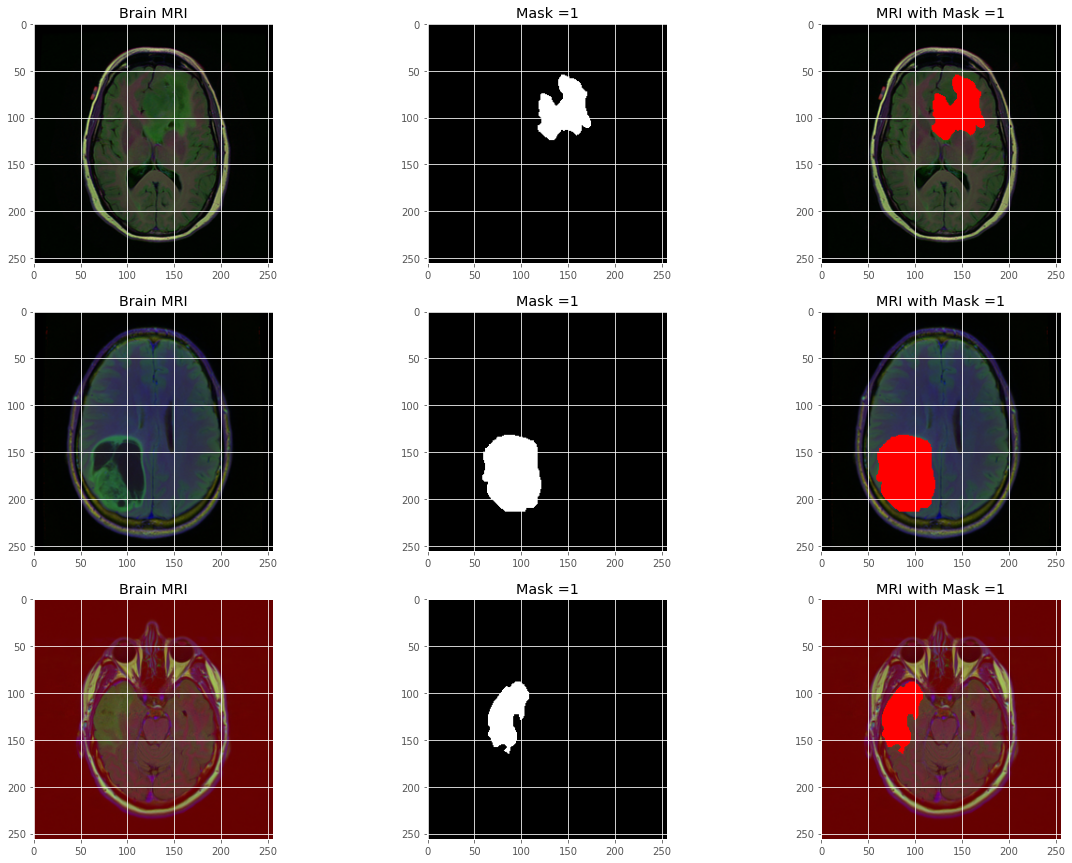

In [35]:
from IPython.display import Image
from skimage import io

count = 0
# generating random number for geenrating random image
i = np.random.randint(len(df)-3)

fig,axes = plt.subplots(3,3, figsize=(20,15))
for mask in df['mask']:
    # plot only if the generated random index mask is 1, otherwise increment 1
    if df.iloc[i]['mask'] == 1:
    #if (mask==1):
        print("Image id: {}".format(i))
        img = io.imread(df.image_path[i])
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][0].title.set_text("Brain MRI")
        axes[count][0].imshow(img)
        
        mask = io.imread(df.mask_path[i])
        axes[count][1].title.set_text("Mask =" + str(df['mask'][i]))
        axes[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][2].title.set_text("MRI with Mask =" + str(df['mask'][i]))
        axes[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.show()

In [36]:
imgg = cv2.imread(df_test['image_path'].iloc[34])
imgk = cv2.resize(imgg, (img_height, img_width))
imgl = imgk/255
# print(img.shape) (256, 256 , 3)
imgx = imgk[np.newaxis, :, :, : ]
img2 = np.squeeze(imgx)
#img_ck = cv2.imread(df.image_path[818])
#img_ck = cv2.cvtColor(img_ck, cv2.COLOR_BGR2RGB)

#imgg = cv2.imread(df_test['image_path'])

#imgg = cv2.imshow(df_test['image_path'].iloc[index], y.astype('float32'))
img1 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#img1 = cv2.imshow(imgg, imgg.astype(np.uint8))
# img1 = img.convert('L')
imgg.shape, imgk.shape, imgl.shape, imgx.shape, img2.shape, img1.shape

((256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (1, 256, 256, 3),
 (256, 256, 3),
 (256, 256))

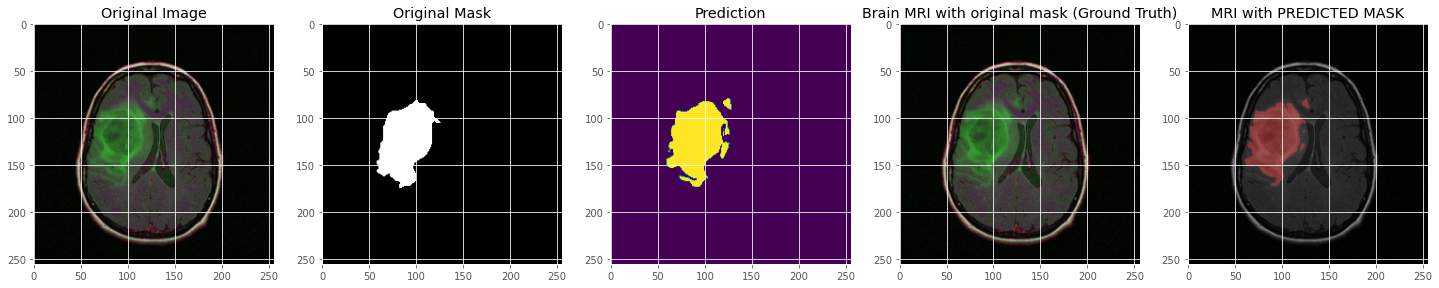

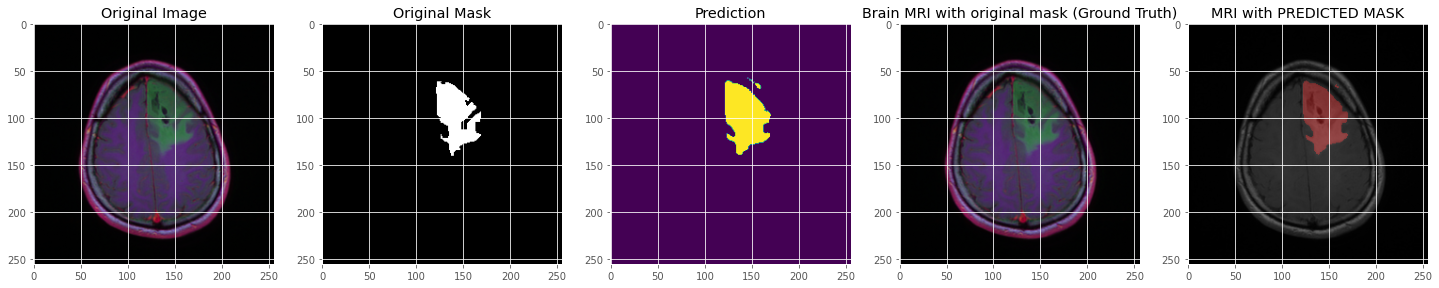

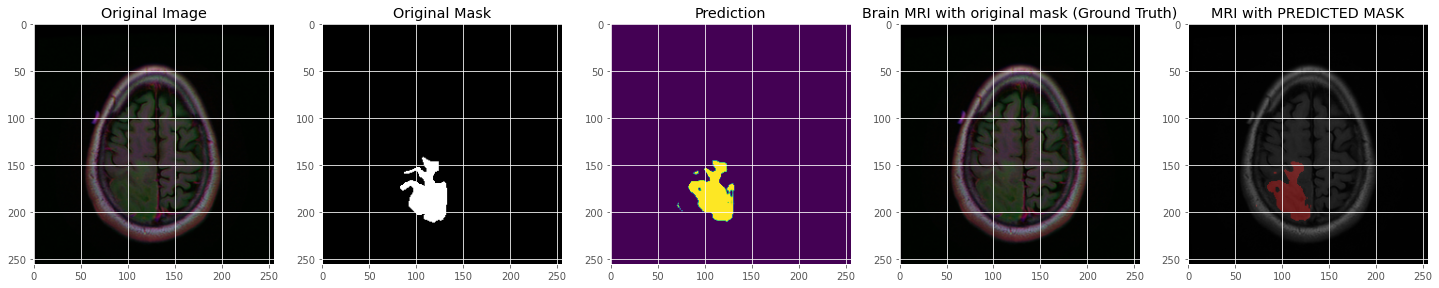

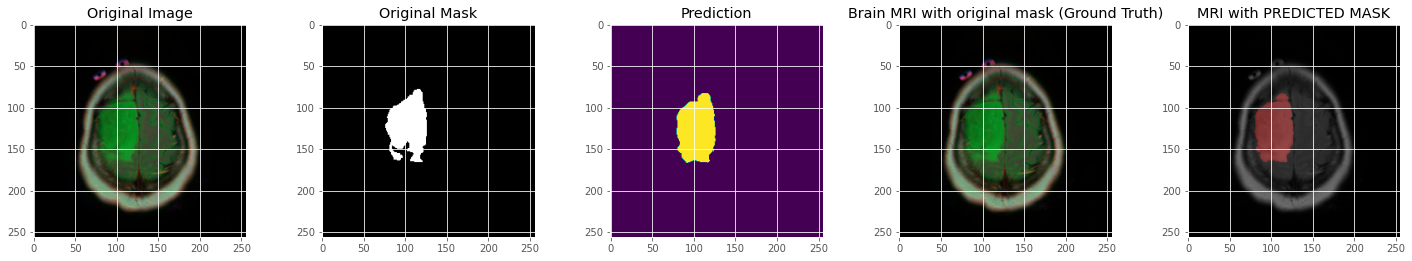

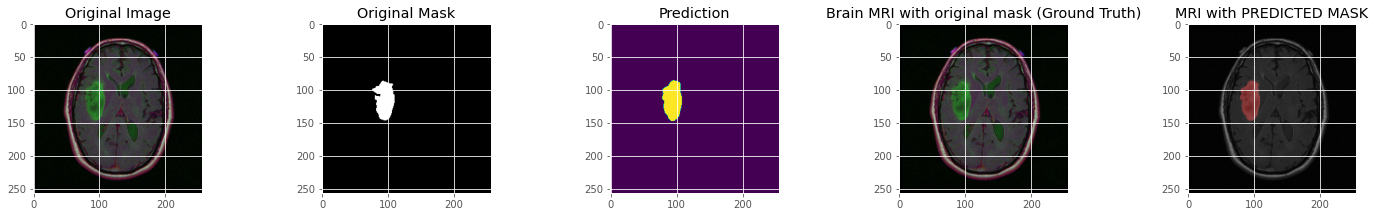

In [49]:
from skimage import color
index = np.random.randint(1, len(df_test.index))
ct = 1
#fig,axes = plt.subplots(10,3)
for mask in df_test['mask']:
    if df_test.iloc[index]['mask'] == 1:
        img = cv2.imread(df_test['image_path'].iloc[index])
        img = cv2.resize(img, (img_height, img_width))
        img = img/255
        # print(img.shape) (256, 256 , 3)
        img = img[np.newaxis, :, :, : ]
        # print(img.shape) # (1, 256, 256, 3)

        predicted_img = model.predict(img)
        
        # original image
        plt.figure(figsize=(25, 18))
        plt.subplot(ct, 5, 1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')

        # ground truth mask
        #plt.figure(figsize=(8, 8))
        plt.subplot(ct, 5, 2)
        # np.squeeze shrinks one dim from (1,256,256,3) to (256,256,3)
        plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
        plt.title('Original Mask')

        # predicted mask
        #plt.figure(figsize=(8, 8))
        plt.subplot(ct, 5, 3)
        plt.imshow(np.squeeze(predicted_img))
        plt.title('Prediction')
        
        #overlay original mask on original image
        plt.subplot(ct,5,4)
        img[mask==255] = (255,0,0)
        plt.imshow(np.squeeze(img))
        plt.title('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask on original image
        plt.subplot(ct, 5, 5)
        img1 = cv2.imread(df_test['image_path'].iloc[index])
        img1 = cv2.resize(img1, (img_height, img_width))
        # the predicted mask image and original image should have same shape
        # so converting original image (256,256,3) to gray scale (256,256)
        gray_img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        result_image = color.label2rgb(np.squeeze(predicted_img), gray_img)
        plt.imshow(result_image)
        plt.title('MRI with PREDICTED MASK')
        
        ct = ct+1
    index += 1
    if ct == 6:
        break

plt.show()

In [46]:
pred = np.array(predicted_img).squeeze().round()
pred1 = predicted_img.squeeze()
pred.shape
print(predicted_img.shape, pred1.shape)

(1, 256, 256, 1) (256, 256)


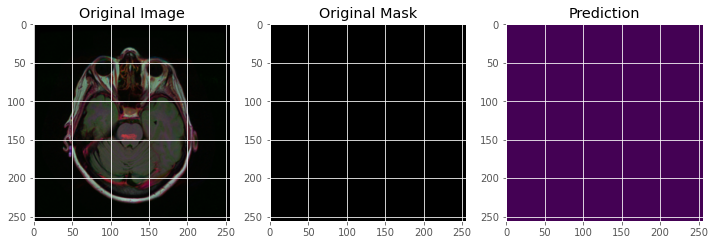

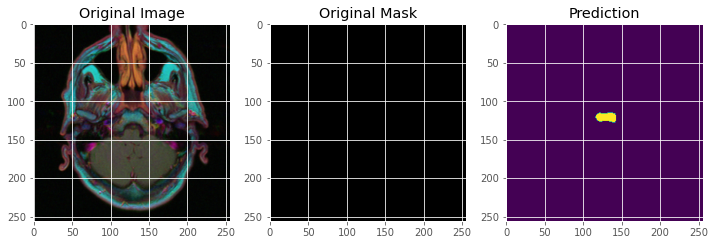

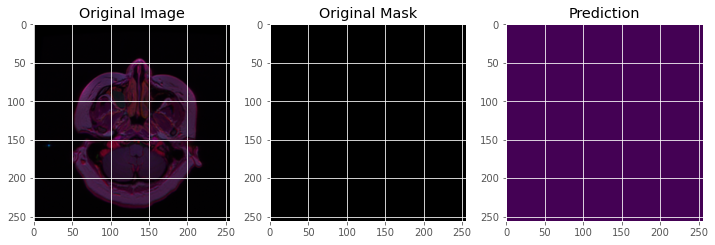

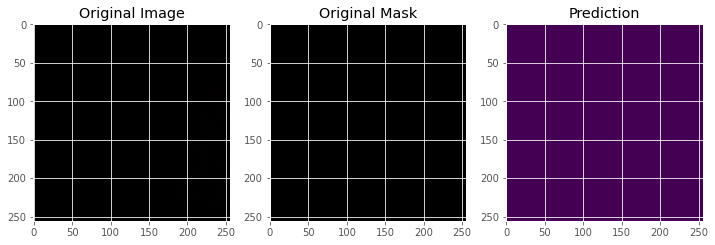

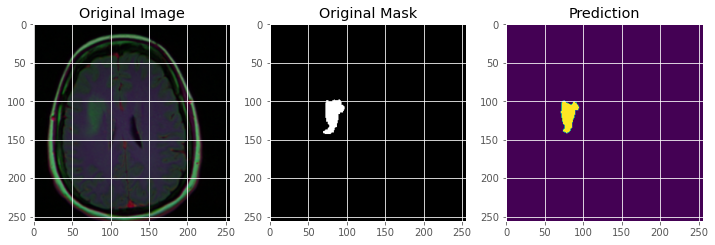

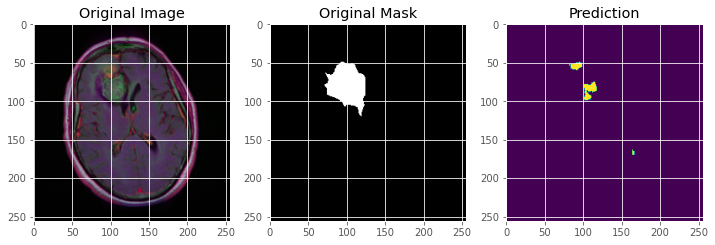

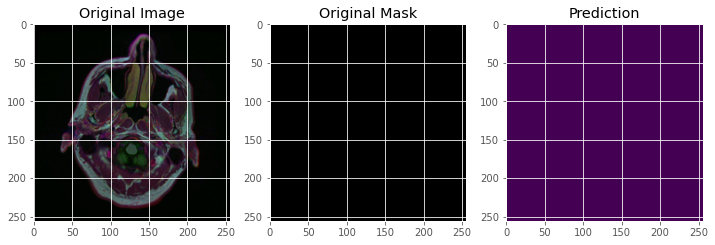

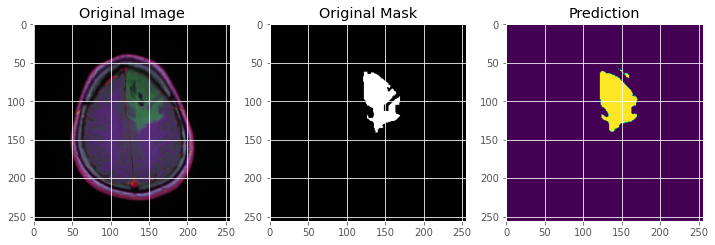

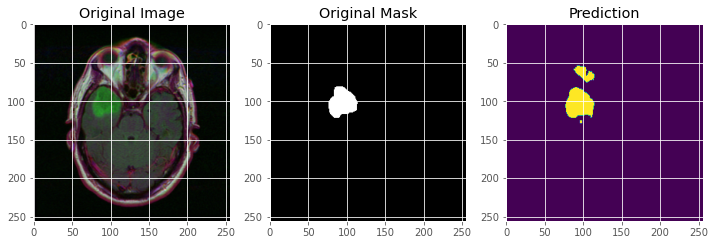

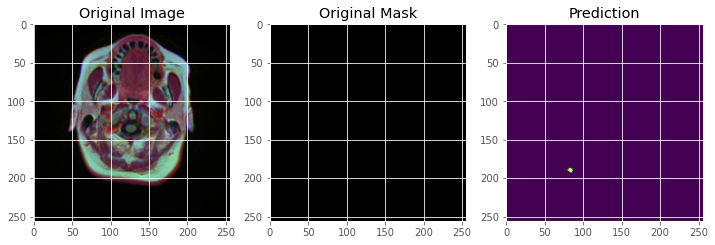

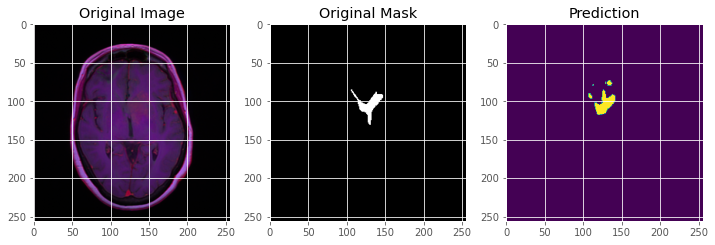

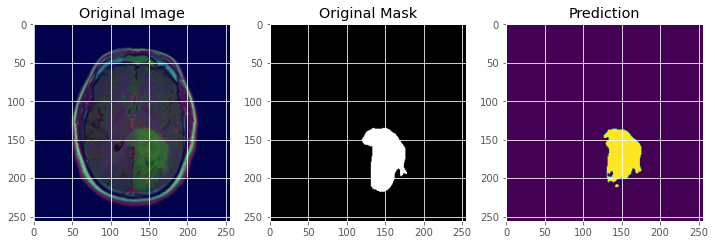

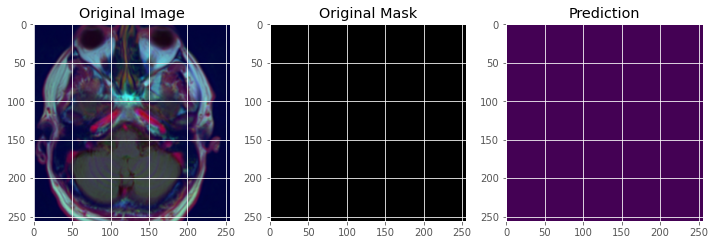

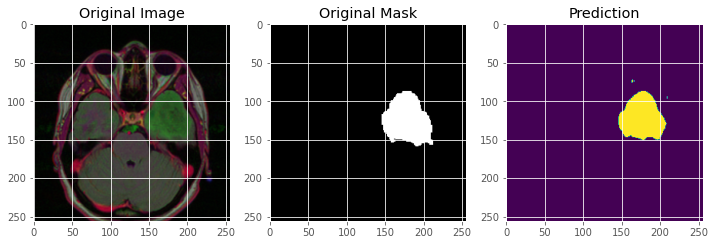

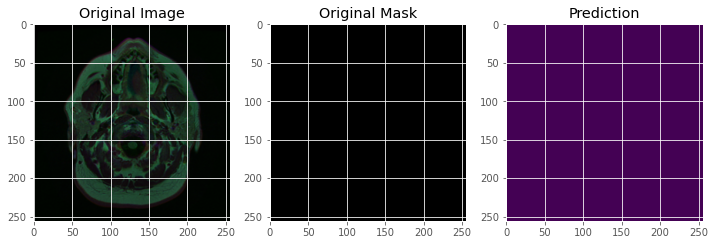

In [44]:
for i in range(15):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img, (img_height, img_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()
